In [1]:
from torchvision.datasets import Omniglot
from torchvision import transforms, models
from torch.utils.data import Sampler, DataLoader
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import torchvision
import torch.nn.functional as F

np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
train = Omniglot(root="./data", download=True,background=True,
    transform=transforms.Compose(
        [
          transforms.Grayscale(num_output_channels=3),
         transforms.Resize(28),
         transforms.ToTensor()
        ]
    )
)
train_size = int(0.8*len(train))
val_size = int(0.2*len(train))

train_data, val_data = torch.utils.data.random_split(train, [train_size, val_size])

test_data = Omniglot(root="./data", download=True,background=False,
    transform=transforms.Compose(
        [
          transforms.Grayscale(num_output_channels=3),
         transforms.Resize(28),
         transforms.ToTensor()
        ]
    ),
)

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting ./data/omniglot-py/images_background.zip to ./data/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting ./data/omniglot-py/images_evaluation.zip to ./data/omniglot-py


In [3]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

15424
3856
13180


torch.Size([3, 28, 28])


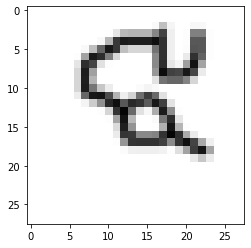

In [4]:
image, label = test_data[50]

print(image.shape)
image=image.permute(1, 2, 0)
plt.imshow(image.numpy())
plt.show()

In [46]:
n=5
n_s=2
n_q =1

In [24]:
class CustomSampler(Sampler):
  def __init__(self, dataset,batch_size,n,n_s, n_q) -> None:
    self.d = {}
    self.n=n
    self.n_s=n_s
    self.n_q=n_q
    self.batch_size=batch_size
    for i,j in enumerate(dataset):
      if j[1] not in self.d:
        self.d[j[1]]=[i]
      else:
        self.d[j[1]].append(i)
    
    # print(len(self.d[0]))

  def __iter__ (self):
    l=[]
    for i in range(self.batch_size):
      labels = random.sample(list(self.d.keys()),self.n)
      x = np.array([random.sample(self.d[j],self.n_s+self.n_q) for j in labels])
      l.append(np.concatenate(x).ravel().tolist())
    return iter(l)

  def __len__(self):
    return self.batch_size

In [11]:
def shuffle(a,b):
  assert len(a)==len(b)
  a = torch.stack(a)
  b = torch.tensor(b,dtype=torch.int)
  p = np.random.permutation(len(a))
  return a[p],b[p]
  # return a,b

def collate_func(batch):
  x_s, y_s, x_q, y_q = [],[],[],[]
  d= {}
  for i,j in batch:
    if j not in d:
      d[j]=[i]
    else:
      d[j].append(i)
  
  for idx, (k,v) in enumerate(d.items()):
    random.shuffle(v)
    # print(len(v))
    y_q+=[idx]*len(v[:n_q])
    x_q+=v[:n_q]
    x_s+= v[n_q:]
    y_s+= [idx]*len(v[n_q:])
  
  # print(len(x_s),len(y_s))
  x_s, y_s = shuffle(x_s,y_s)
  x_q, y_q = shuffle(x_q, y_q)

  return x_s,y_s,x_q,y_q

In [12]:
batches = CustomSampler(train_data,8,n,n_s,n_q)
for i in batches:
  print(i)

13
[14963, 9525, 1311, 12926, 14824, 5543, 5922, 8105, 11283, 4696, 4337, 6848, 13274, 4409, 9922, 12197, 4422, 7183, 13456, 1408, 352, 8196, 10058, 12223, 8726, 10531, 8813, 5350, 1526, 9441, 5963, 6021, 3458]
[9047, 10685, 6912, 11335, 1421, 12698, 7463, 3706, 7577, 6013, 707, 11751, 14767, 1664, 7589, 13541, 5011, 1546, 4765, 13232, 9522, 2538, 7260, 6626, 10736, 15183, 14793, 5615, 5132, 13518, 11719, 6052, 2063]
[6479, 5188, 14754, 12289, 12252, 5425, 1654, 4083, 9473, 8419, 4147, 6517, 3440, 12793, 6406, 11685, 1454, 560, 7874, 4471, 3481, 7867, 5509, 2024, 4477, 1418, 7470, 6705, 8389, 11701, 5807, 9830, 63]
[13600, 15092, 1010, 10490, 2472, 9741, 1954, 13402, 1282, 8670, 8008, 8828, 525, 3051, 5991, 6267, 6669, 1764, 3332, 3121, 11291, 2496, 1626, 11313, 2886, 12827, 5372, 6186, 3285, 5792, 7355, 7315, 14751]
[5103, 1983, 4464, 4297, 14300, 13235, 6197, 7786, 13467, 2906, 11735, 10188, 11097, 5121, 12164, 2381, 6418, 3747, 1900, 14920, 541, 6235, 798, 1545, 13763, 12757, 13208,

In [13]:
x = DataLoader(train_data, batch_sampler=batches, collate_fn=collate_func)
for xs,ys,xq,yq in x:
  print(xq.shape)
  print(yq)
  print(xs.shape)
  print(ys)

torch.Size([30, 3, 28, 28])
tensor([1, 2, 1, 0, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 1, 2, 2, 0, 1, 0, 0, 1, 2, 1,
        0, 0, 2, 0, 0, 2], dtype=torch.int32)
torch.Size([3, 3, 28, 28])
tensor([2, 1, 0], dtype=torch.int32)
torch.Size([30, 3, 28, 28])
tensor([2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 0, 0, 1, 0, 0, 1, 2, 0, 1, 1, 0, 2, 1, 2,
        0, 0, 0, 0, 1, 1], dtype=torch.int32)
torch.Size([3, 3, 28, 28])
tensor([0, 2, 1], dtype=torch.int32)
torch.Size([30, 3, 28, 28])
tensor([2, 0, 0, 0, 0, 1, 2, 2, 0, 1, 2, 1, 1, 1, 2, 0, 2, 1, 1, 2, 2, 0, 1, 1,
        1, 2, 0, 0, 2, 0], dtype=torch.int32)
torch.Size([3, 3, 28, 28])
tensor([0, 2, 1], dtype=torch.int32)
torch.Size([30, 3, 28, 28])
tensor([1, 1, 2, 0, 0, 1, 0, 2, 2, 1, 2, 2, 0, 2, 1, 1, 1, 2, 1, 0, 0, 1, 2, 2,
        2, 0, 0, 0, 0, 1], dtype=torch.int32)
torch.Size([3, 3, 28, 28])
tensor([2, 0, 1], dtype=torch.int32)
torch.Size([30, 3, 28, 28])
tensor([2, 0, 1, 2, 0, 2, 1, 1, 2, 1, 0, 1, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0, 2, 2,
        1, 2, 2, 1, 

In [14]:
def view_batch(x_s):
  grid_img = torchvision.utils.make_grid(x_s)
  plt.imshow(grid_img.permute(1, 2, 0))  

tensor([1, 0, 2], dtype=torch.int32)


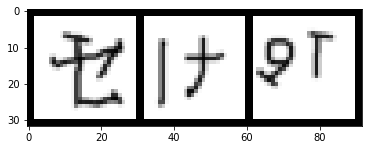

In [15]:
view_batch(xs)
print(ys)

tensor([2, 1, 1, 1, 0, 0, 2, 1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 2, 1, 2, 2, 1, 2, 0,
        2, 0, 1, 2, 0, 2], dtype=torch.int32)


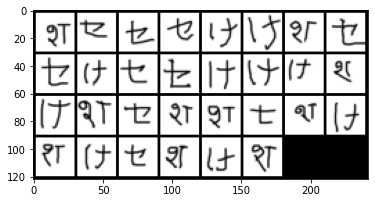

In [16]:
view_batch(xq)
print(yq)

In [17]:
class ProtoNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    model = models.resnet18(pretrained=True)
    self.conv_net = torch.nn.Sequential(*list(model.children())[:-1])
  
  def forward(self, xs, ys, xq):
    x = self.conv_net(xs)
    N = xq.shape[0]

    prot = torch.stack([x[ys==i].mean(0) for i in range(N)]).detach()

    # print(prot.shape)
    pred = self.conv_net(xq)
    # print(pred.shape)

    dist = torch.zeros((pred.shape[0], prot.shape[0]))

    for i in range(N):
        t = torch.zeros(prot.shape[0])
        for j in range(prot.shape[0]):
            t[j] = torch.dist(pred[i],prot[j],2)
        dist[i] = -t
    return dist

In [47]:
batches = CustomSampler(train_data,16,n,n_s,n_q)
x = DataLoader(train_data, batch_sampler=batches, collate_fn=collate_func)
# x = next(iter(x))

In [48]:
model = ProtoNet()
model.to(device)
# dist = model(x[0],x[1],x[2])

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ProtoNet(
  (conv_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [45]:
# for i in model.children():
#   print(i)
# print(model)

ProtoNet(
  (conv_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [49]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [50]:
len(x)

16

In [51]:
def train(model, loss_func, optimizer, scheduler=None, epochs=15000):
  for epoch in range(epochs):
    
    running_loss = 0.0
    running_corrects = 0
    total =0

    for inputs in x:
      xs,ys,xq,yq = inputs
      xs=xs.to(device)
      xq=xq.to(device)
      ys=ys.to(device)
      yq=yq.to(device)

      optimizer.zero_grad()

      out = model(xs,ys,xq)
      loss = loss_func(out, yq.type(torch.LongTensor))
      if device!= "cpu":
        preds = torch.argmax(out, dim=-1).cuda()

      loss.backward()
      optimizer.step()

      running_loss += loss.item() * xq.size(0)
      running_corrects += torch.sum(preds == yq.data)
      total+=len(yq.data)
    
    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total

    if epoch==0 or (epoch+1) %200 ==0:
      print(f'Epoch {epoch}/{epochs - 1}:- Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
      print('-' * 10)
    

In [52]:
train(model, loss, optimizer)

Epoch 0/14999:- Loss: 0.8307 Acc: 0.7250
----------
Epoch 199/14999:- Loss: 0.6658 Acc: 0.9125
----------
Epoch 399/14999:- Loss: 0.4490 Acc: 0.9250
----------
Epoch 599/14999:- Loss: 0.1144 Acc: 0.9750
----------
Epoch 799/14999:- Loss: 0.2889 Acc: 0.9375
----------
Epoch 999/14999:- Loss: 0.3476 Acc: 0.9375
----------
Epoch 1199/14999:- Loss: 0.2503 Acc: 0.9000
----------


KeyboardInterrupt: ignored